In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.stats import ttest_ind


In [2]:
root_dir = './maddpg/model/'

In [3]:
dirs = os.listdir(root_dir)
if '.ipynb_checkpoints' in dirs:
    dirs.remove('.ipynb_checkpoints')
dirs = sorted(dirs)


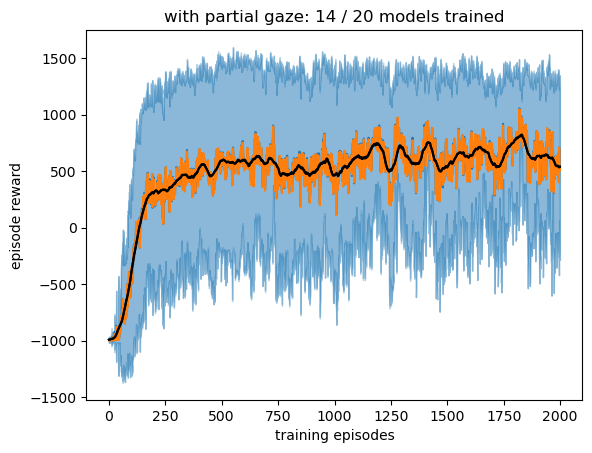

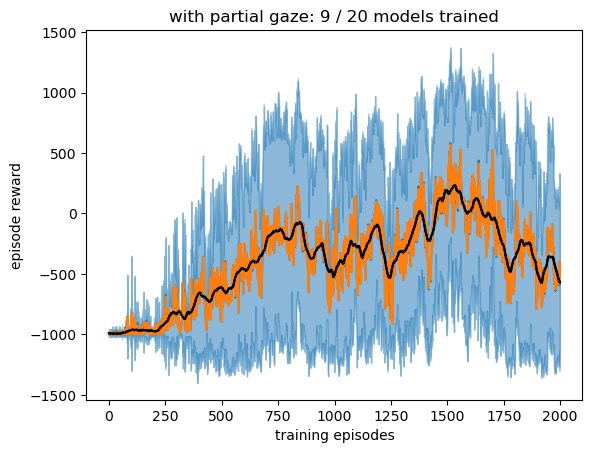

In [5]:
# get reward functions!
for model_dir in dirs:
    good = np.load(root_dir + model_dir + '/good_folds.npy', allow_pickle=True).item()
    num_models = len(list(good.keys()))
    tot_models = 10 * (len(os.listdir(root_dir + model_dir)) // 10)
    eps = 2000 if model_dir != 'no_embed_full' else 1400
    
    all_ret1 = np.zeros((num_models, eps))
    all_ret2 = np.zeros((num_models, eps))
    for i, g in enumerate(good):
        ret1 = np.load(root_dir + model_dir + '/' +  g + '/returns1.npy', allow_pickle=True)
        ret2 = np.load(root_dir + model_dir + '/' +  g + '/returns2.npy', allow_pickle=True)
        try:
            all_ret1[i] = ret1[:eps]
            all_ret2[i] = ret2[:eps]
        except:
            print(g)
    
    mean_ret1 = np.mean(all_ret1, axis=0)
    std_ret1 = np.std(all_ret1, axis=0)
    
    mean_ret2 = np.mean(all_ret2, axis=0)
    std_ret2 = np.std(all_ret2, axis=0)
    
    plt.plot(mean_ret1, color='tab:blue')
    plt.plot(mean_ret2, color='tab:orange')

    x = np.arange(eps)
    plt.fill_between(x, mean_ret1 - std_ret1, mean_ret1 + std_ret1, color='tab:blue', alpha=0.3)
    plt.fill_between(x, mean_ret2 - std_ret2, mean_ret2 + std_ret2, color='tab:blue', alpha=0.3)
    
    window = 50  # You can adjust this value for more or less smoothing
    smooth_ret1 = uniform_filter1d(mean_ret1, size=window, mode='nearest')
    smooth_ret2 = uniform_filter1d(mean_ret2, size=window, mode='nearest')
    
    plt.plot(smooth_ret1, color='k')
    plt.plot(smooth_ret2, color='k')
    plt.title(f'with partial gaze: {num_models} / {tot_models} models trained')
    plt.xlabel('training episodes')
    plt.ylabel('episode reward')
    plt.show()

In [6]:
from metrics import get_gaze, get_reward, get_repress

In [7]:
# Example setup
model_names = dirs
num_dir = len(model_names)

# Example data shape: each list contains arrays of shape (n_runs,)
# Replace this with your actual data structure
# Example: all_ret1_models[0] is a list of returns for Model A's condition 1

all_ret1_models = []
all_ret2_models = []

for model_dir in dirs:
    good = np.load(root_dir + model_dir + '/good_folds.npy', allow_pickle=True).item()
    num_models = len(list(good.keys()))
    tot_models = 10 * (len(os.listdir(root_dir + model_dir)) // 10)
    eps = 2000 if model_dir != 'no_embed_full' else 1400
    
    all_ret1 = np.zeros(num_models)
    all_ret2 = np.zeros(num_models)
    for i, g in enumerate(good):
        filepath = root_dir + model_dir + '/evaluate/' + g + '_evaluate'
        gaze1, gaze2 = get_gaze(filepath)
        all_ret1[i] = gaze1
        all_ret2[i] = gaze2
    all_ret1_models.append(all_ret1)
    all_ret2_models.append(all_ret2)




-1.1485225552307448 0.2569586392035991


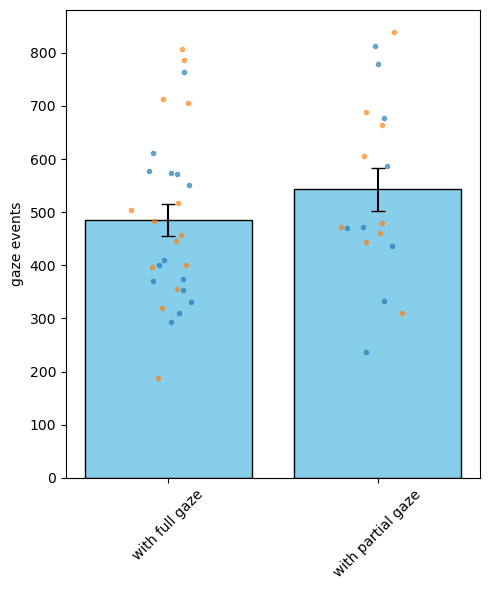

In [8]:
# Combine ret1 and ret2 for each model
combined_returns = [np.concatenate([ret1, ret2]) for ret1, ret2 in zip(all_ret1_models, all_ret2_models)]

# Compute means and standard errors
means = [np.mean(ret) for ret in combined_returns]
stds = [np.std(ret) for ret in combined_returns]
ses = [np.std(ret) / np.sqrt(len(ret)) for ret in combined_returns]

# Bar plot
x = np.arange(num_dir)
fig, ax = plt.subplots(figsize=(5, 6))

bars = ax.bar(x, means, yerr=ses, capsize=5, color='skyblue', edgecolor='black')

# Add individual dots (ret1 in blue, ret2 in orange)
for i in range(num_dir):
    jitter = 0.08
    ax.plot(np.random.normal(x[i], jitter, size=len(all_ret1_models[i])), all_ret1_models[i], '.', color='tab:blue', alpha=0.6, label='Return 1' if i == 0 else "")
    ax.plot(np.random.normal(x[i], jitter, size=len(all_ret2_models[i])), all_ret2_models[i], '.', color='tab:orange', alpha=0.6, label='Return 2' if i == 0 else "")

t_stat, p_val = ttest_ind(combined_returns[0], combined_returns[1])
print(t_stat, p_val)

# Final touches
ax.set_xticks(x)
ax.set_xticklabels(['with full gaze', 'with partial gaze'], rotation=45)
ax.set_ylabel("gaze events")
plt.tight_layout()
plt.show()


In [9]:
def get_repress2(filepath):
    pulls = np.load(filepath + '/all_pulls.pkl', allow_pickle=True)
    rewards = np.load(filepath + '/all_rewards.pkl', allow_pickle=True)
    repress1 = 0
    repress2 = 0
    for eps in rewards.keys():
        pull1 = pulls[eps][0]
        pull2 = pulls[eps][1]
        for r in rewards[eps][0]:
            pp1 = [x for x in pull1 if x  < r]
            pp2 = [x for x in pull2 if x  < r]
            repress1 += (len(pp1) - 1)
            repress2 += (len(pp2) - 1)
            pull1 = [x for x in pull1 if x not in pp1]
            pull2 = [x for x in pull2 if x not in pp2]
    return repress1 / 1000, repress2 / 1000

In [10]:
# Example setup
model_names = dirs
num_dir = len(model_names)

all_ret1_models = []
all_ret2_models = []

for model_dir in dirs:
    good = np.load(root_dir + model_dir + '/good_folds.npy', allow_pickle=True).item()
    if 'baseline_pause_13' in good:
        value = good.pop('baseline_pause_13', None)
    num_models = len(list(good.keys()))
    tot_models = 10 * (len(os.listdir(root_dir + model_dir)) // 10)
    eps = 2000 if model_dir != 'no_embed_full' else 1400
    
    all_ret1 = np.zeros(num_models)
    all_ret2 = np.zeros(num_models)
    for i, g in enumerate(good):
        
        filepath = root_dir + model_dir + '/evaluate/' + g + '_evaluate'
        reward1, reward2 = get_repress2(filepath)
        
        all_ret1[i] = reward1
        all_ret2[i] = reward1
    all_ret1_models.append(all_ret1)
    all_ret2_models.append(all_ret2)


-2.1071085031131416 0.04112059503647883


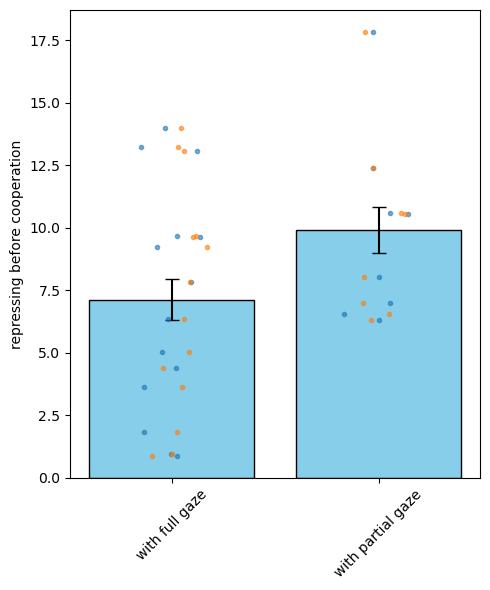

In [61]:
# Combine ret1 and ret2 for each model
combined_returns = [np.concatenate([ret1, ret2]) for ret1, ret2 in zip(all_ret1_models, all_ret2_models)]

# Compute means and standard errors
means = [np.mean(ret) for ret in combined_returns]
stds = [np.std(ret) for ret in combined_returns]
ses = [np.std(ret) / np.sqrt(len(ret)) for ret in combined_returns]

# Bar plot
x = np.arange(num_dir)
fig, ax = plt.subplots(figsize=(5, 6))

bars = ax.bar(x, means, yerr=ses, capsize=5, color='skyblue', edgecolor='black')

# Add individual dots (ret1 in blue, ret2 in orange)
for i in range(num_dir):
    jitter = 0.08
    ax.plot(np.random.normal(x[i], jitter, size=len(all_ret1_models[i])), all_ret1_models[i], '.', color='tab:blue', alpha=0.6, label='Return 1' if i == 0 else "")
    ax.plot(np.random.normal(x[i], jitter, size=len(all_ret2_models[i])), all_ret2_models[i], '.', color='tab:orange', alpha=0.6, label='Return 2' if i == 0 else "")

t_stat, p_val = ttest_ind(combined_returns[0], combined_returns[1])
print(t_stat, p_val)

# plt.hlines(500, -0.5, 5.5, linestyle='dashed', color='k')
# Final touches
ax.set_xticks(x)
ax.set_xticklabels(['with full gaze', 'with partial gaze'], rotation=45)
ax.set_ylabel("repressing before cooperation")
plt.tight_layout()
plt.show()


In [11]:
# Example setup
model_names = dirs
num_dir = len(model_names)

all_ret1_models = []
all_ret2_models = []

for model_dir in dirs:
    good = np.load(root_dir + model_dir + '/good_folds.npy', allow_pickle=True).item()
    if 'baseline_pause_13' in good:
        value = good.pop('baseline_pause_13', None)
    num_models = len(list(good.keys()))
    tot_models = 10 * (len(os.listdir(root_dir + model_dir)) // 10)
    eps = 2000 if model_dir != 'no_embed_full' else 1400
    
    all_ret1 = np.zeros(num_models)
    all_ret2 = np.zeros(num_models)
    for i, g in enumerate(good):
        
        filepath = root_dir + model_dir + '/evaluate/' + g + '_evaluate'
        reward1, reward2 = get_reward(filepath)
        
        all_ret1[i] = reward1
        all_ret2[i] = reward1
    all_ret1_models.append(all_ret1)
    all_ret2_models.append(all_ret2)


5.248676247336011 4.731862825613269e-06


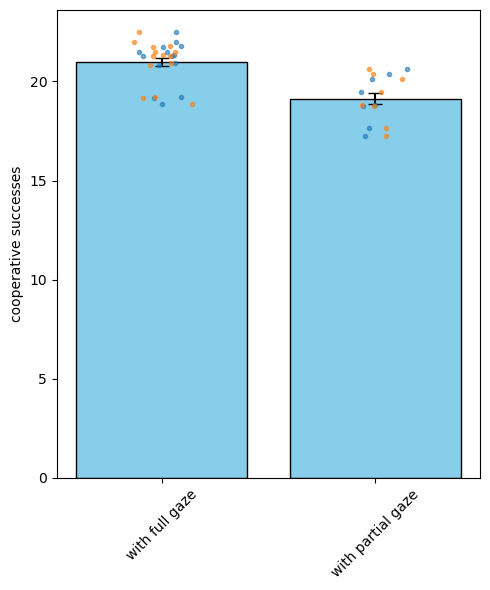

In [12]:
# Combine ret1 and ret2 for each model
combined_returns = [np.concatenate([ret1, ret2]) for ret1, ret2 in zip(all_ret1_models, all_ret2_models)]

# Compute means and standard errors
means = [np.mean(ret) for ret in combined_returns]
stds = [np.std(ret) for ret in combined_returns]
ses = [np.std(ret) / np.sqrt(len(ret)) for ret in combined_returns]

# Bar plot
x = np.arange(num_dir)
fig, ax = plt.subplots(figsize=(5, 6))

bars = ax.bar(x, means, yerr=ses, capsize=5, color='skyblue', edgecolor='black')

# Add individual dots (ret1 in blue, ret2 in orange)
for i in range(num_dir):
    jitter = 0.08
    ax.plot(np.random.normal(x[i], jitter, size=len(all_ret1_models[i])), all_ret1_models[i], '.', color='tab:blue', alpha=0.6, label='Return 1' if i == 0 else "")
    ax.plot(np.random.normal(x[i], jitter, size=len(all_ret2_models[i])), all_ret2_models[i], '.', color='tab:orange', alpha=0.6, label='Return 2' if i == 0 else "")

t_stat, p_val = ttest_ind(combined_returns[0], combined_returns[1])
print(t_stat, p_val)

# plt.hlines(500, -0.5, 5.5, linestyle='dashed', color='k')
# Final touches
ax.set_xticks(x)
ax.set_xticklabels(['with full gaze', 'with partial gaze'], rotation=45)
ax.set_ylabel("cooperative successes")
plt.tight_layout()
plt.show()


In [76]:
def get_interpress2(filepath):
    pulls = np.load(filepath + '/all_pulls.pkl', allow_pickle=True)
    rewards = np.load(filepath + '/all_rewards.pkl', allow_pickle=True)
    interpress = []
    for eps in rewards.keys():
        pull1 = pulls[eps][0]
        pull2 = pulls[eps][1]
        for r in rewards[eps][0]:
            pp1 = [x for x in pull1 if x  < r]
            pp2 = [x for x in pull2 if x  < r]
            all_p = np.concatenate((pp1, pp2)) 
            
            try: 
                max_p = np.max(all_p)
                
                if max_p in pp1:
                    
                    intt = max_p - np.min(pp2)
                    if intt > 7:
                        inter = max_p * np.ones(len(pp2)) - (pp2)
                        inter = [x for x in inter if x <= 7]
                        inter = np.max(inter)
                    interpress.append(intt)
                else:
                    intt = max_p - np.min(pp1)
                    if intt > 7:
                        inter = max_p * np.ones(len(pp1)) - (pp1)
                        inter = [x for x in inter if x <= 7]
                        inter = np.max(inter)
                    interpress.append(intt)
                pull1 = [x for x in pull1 if x not in pp1]
                pull2 = [x for x in pull2 if x not in pp2]
            except:
                continue
            # find max
            # find min in other
            # subtract...

            
    return np.mean(interpress)

In [77]:
# Example setup
model_names = dirs
num_dir = len(model_names)

all_ret1_models = []

for model_dir in dirs:
    good = np.load(root_dir + model_dir + '/good_folds.npy', allow_pickle=True).item()
    if 'baseline_pause_13' in good:
        value = good.pop('baseline_pause_13', None)
    num_models = len(list(good.keys()))
    tot_models = 10 * (len(os.listdir(root_dir + model_dir)) // 10)
    eps = 2000 if model_dir != 'no_embed_full' else 1400
    
    all_ret1 = np.zeros(num_models)
    for i, g in enumerate(good):
        
        filepath = root_dir + model_dir + '/evaluate/' + g + '_evaluate'
        interpress = get_interpress2(filepath)
        all_ret1[i] = interpress
    all_ret1_models.append(all_ret1)


-2.132820581070038 0.04551903316241543


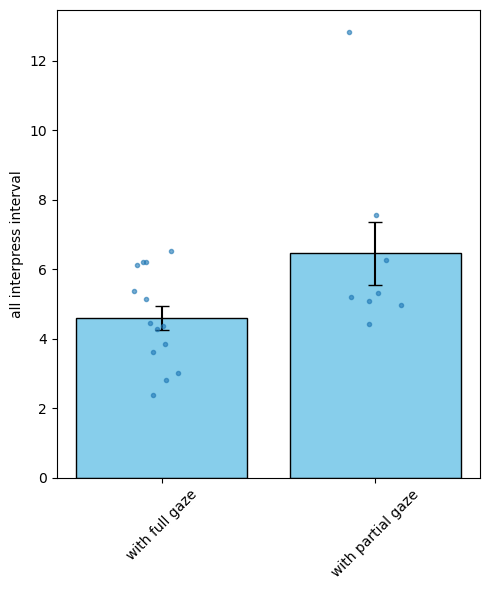

In [79]:
# Combine ret1 and ret2 for each model
combined_returns = all_ret1_models # [np.concatenate([ret1, ret2]) for ret1, ret2 in zip(all_ret1_models, all_ret2_models)]

# Compute means and standard errors
means = [np.mean(ret) for ret in combined_returns]
stds = [np.std(ret) for ret in combined_returns]
ses = [np.std(ret) / np.sqrt(len(ret)) for ret in combined_returns]

# Bar plot
x = np.arange(num_dir)
fig, ax = plt.subplots(figsize=(5, 6))

bars = ax.bar(x, means, yerr=ses, capsize=5, color='skyblue', edgecolor='black')

# Add individual dots (ret1 in blue, ret2 in orange)
for i in range(num_dir):
    jitter = 0.08
    ax.plot(np.random.normal(x[i], jitter, size=len(all_ret1_models[i])), all_ret1_models[i], '.', color='tab:blue', alpha=0.6, label='Return 1' if i == 0 else "")
    # ax.plot(np.random.normal(x[i], jitter, size=len(all_ret2_models[i])), all_ret2_models[i], '.', color='tab:orange', alpha=0.6, label='Return 2' if i == 0 else "")

t_stat, p_val = ttest_ind(combined_returns[0], combined_returns[1])
print(t_stat, p_val)

# plt.hlines(500, -0.5, 5.5, linestyle='dashed', color='k')
# Final touches
ax.set_xticks(x)
ax.set_xticklabels(['with full gaze', 'with partial gaze'], rotation=45)
ax.set_ylabel("all interpress interval")
plt.tight_layout()
plt.show()


In [106]:
def get_ratid(filepath):
    pulls = np.load(filepath + '/all_pulls.pkl', allow_pickle=True)
    rewards = np.load(filepath + '/all_rewards.pkl', allow_pickle=True)
    interpress = []
    for eps in rewards.keys():
        pull1 = pulls[eps][0]
        pull2 = pulls[eps][1]
        for r in rewards[eps][0]:
            pp1 = [x for x in pull1 if x  < r]
            pp2 = [x for x in pull2 if x  < r]
            all_p = np.concatenate((pp1, pp2)) 
            
            try: 
                max_p = np.max(all_p)
                
                if max_p in pp1:
                    
                    interpress.append(1)
                else:
                    interpress.append(0)
                pull1 = [x for x in pull1 if x not in pp1]
                pull2 = [x for x in pull2 if x not in pp2]
            except:
                continue
            # find max
            # find min in other
            # subtract...
    rat_id = np.mean(interpress)
    return rat_id if rat_id > 0.5 else 1 - rat_id

In [107]:
# Example setup
model_names = dirs
num_dir = len(model_names)

all_ret1_models = []

for model_dir in dirs:
    good = np.load(root_dir + model_dir + '/good_folds.npy', allow_pickle=True).item()
    if 'baseline_pause_13' in good:
        value = good.pop('baseline_pause_13', None)
    num_models = len(list(good.keys()))
    tot_models = 10 * (len(os.listdir(root_dir + model_dir)) // 10)
    eps = 2000 if model_dir != 'no_embed_full' else 1400
    
    all_ret1 = np.zeros(num_models)
    for i, g in enumerate(good):
        
        filepath = root_dir + model_dir + '/evaluate/' + g + '_evaluate'
        interpress = get_ratid(filepath)
        all_ret1[i] = interpress
    all_ret1_models.append(all_ret1)


3.127570072459506 0.0053024610396028545


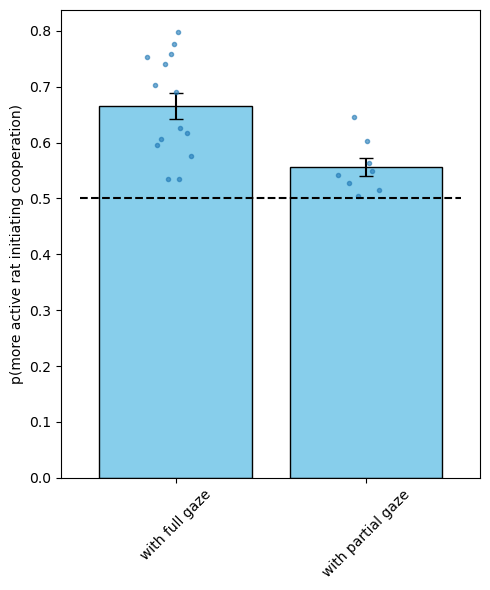

In [114]:
# Combine ret1 and ret2 for each model
combined_returns = all_ret1_models # [np.concatenate([ret1, ret2]) for ret1, ret2 in zip(all_ret1_models, all_ret2_models)]

# Compute means and standard errors
means = [np.mean(ret) for ret in combined_returns]
stds = [np.std(ret) for ret in combined_returns]
ses = [np.std(ret) / np.sqrt(len(ret)) for ret in combined_returns]

# Bar plot
x = np.arange(num_dir)
fig, ax = plt.subplots(figsize=(5, 6))

bars = ax.bar(x, means, yerr=ses, capsize=5, color='skyblue', edgecolor='black')

# Add individual dots (ret1 in blue, ret2 in orange)
for i in range(num_dir):
    jitter = 0.08
    ax.plot(np.random.normal(x[i], jitter, size=len(all_ret1_models[i])), all_ret1_models[i], '.', color='tab:blue', alpha=0.6, label='Return 1' if i == 0 else "")
    # ax.plot(np.random.normal(x[i], jitter, size=len(all_ret2_models[i])), all_ret2_models[i], '.', color='tab:orange', alpha=0.6, label='Return 2' if i == 0 else "")

t_stat, p_val = ttest_ind(combined_returns[0], combined_returns[1])
print(t_stat, p_val)

# plt.hlines(500, -0.5, 5.5, linestyle='dashed', color='k')
# Final touches
plt.hlines(.5, -0.5, 1.5, 'k', linestyle='dashed')
ax.set_xticks(x)
ax.set_xticklabels(['with full gaze', 'with partial gaze'], rotation=45)
ax.set_ylabel("p(more active rat initiating cooperation)")
plt.tight_layout()
plt.show()


In [139]:
from collections import Counter

In [148]:
def get_actions(filepath):
    actions = np.load(filepath + '/all_actions.pkl', allow_pickle=True)

    mv_act = []
    gz_act = []
    for eps in actions.keys():
        
        act1 = actions[eps][0]
        act2 = actions[eps][1]
        for i, a1 in enumerate(act1):
            if a1[1] == 0:
                mv_act.append(a1[0])
            else:
                gz_act.append(a1[0])

            if act2[i][1] == 0:
                mv_act.append(act2[i][0])
            else:
                gz_act.append(act2[i][0])
    mv_count = Counter(mv_act)   
    gz_count = Counter(gz_act) 

    mv_act = np.array([mv_count[0], mv_count[1], mv_count[2]])
    gz_act = np.array([gz_count[0], gz_count[1], gz_count[2]])
    return mv_act / 1000, gz_act / 1000

In [149]:
# Example setup
model_names = dirs
num_dir = len(model_names)

all_ret1_models = []
all_ret2_models = []

for model_dir in dirs:
    good = np.load(root_dir + model_dir + '/good_folds.npy', allow_pickle=True).item()
    if 'baseline_pause_13' in good:
        value = good.pop('baseline_pause_13', None)
    num_models = len(list(good.keys()))
    tot_models = 10 * (len(os.listdir(root_dir + model_dir)) // 10)
    eps = 2000 if model_dir != 'no_embed_full' else 1400
    
    all_ret1 = np.zeros((num_models, 3))
    all_ret2 = np.zeros((num_models, 3))
    for i, g in enumerate(good):
        
        filepath = root_dir + model_dir + '/evaluate/' + g + '_evaluate'
        mv_act, gz_act = get_actions(filepath)
        all_ret1[i] = mv_act
        all_ret2[i] = gz_act
    all_ret1_models.append(all_ret1)
    all_ret2_models.append(all_ret2)


[149.523 559.652 489.258] [103.613 300.964 396.99 ]
[128.29  371.385 456.478] [196.978 465.754 381.115]
[264.595 501.027 320.621] [166.383 283.668 463.706]
[147.139 562.701 513.589] [ 91.516 317.827 367.228]
[152.637 565.252 516.698] [ 88.895 314.009 362.509]
[124.531 375.631 478.57 ] [157.768 483.284 380.216]
[ 91.283 413.721 314.388] [128.815 476.361 575.432]
[140.847 469.382 638.783] [ 87.463 416.562 246.963]
[159.854 603.595 572.011] [ 74.318 279.487 310.735]
[137.754 288.805 416.878] [180.939 552.033 423.591]
[ 57.173 220.123 252.552] [161.24  670.761 638.151]
[118.746 368.607 443.029] [143.864 500.184 425.57 ]
[146.752 393.73  431.905] [134.858 465.908 426.847]
[144.278 413.581 510.139] [134.156 447.727 350.119]
[147.285 391.32  520.091] [132.504 467.939 340.861]
[133.736 367.307 359.437] [155.904 488.555 495.061]
[179.311 418.909 475.339] [112.888 435.078 378.475]
[150.806 426.012 390.812] [146.547 424.938 460.885]
[153.177 296.018 509.2  ] [186.015 538.391 317.199]
[119.961 384

In [173]:
t_stat, p_val = ttest_ind(all_ret2_models[1][:, 1], all_ret2_models[1][:, 2])
print(t_stat, p_val)

1.0436121175224273 0.31435131183404535


In [172]:
t_stat, p_val = ttest_ind(all_ret1_models[1][:, 1], all_ret1_models[1][:, 2])
print(t_stat, p_val)

-1.015562347348788 0.32706834035077603


In [175]:
data = all_ret1_models

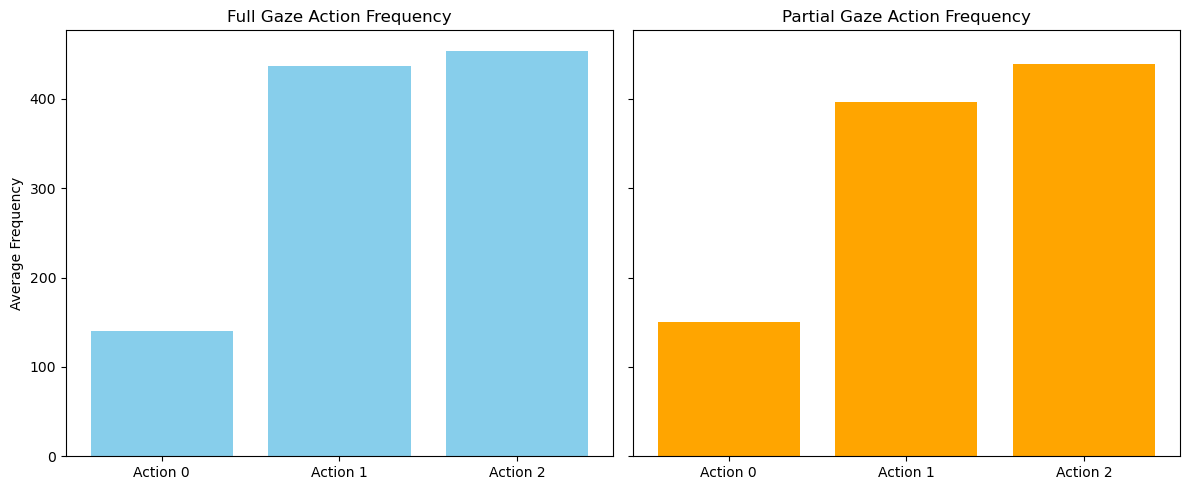

In [176]:
# Aggregate counts of actions for each model
model1_action_counts = np.mean(data[0], axis=0) 
model2_action_counts = np.mean(data[1], axis=0)

# Plotting
actions = ['Action 0', 'Action 1', 'Action 2']
x = np.arange(len(actions))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Model 1 histogram
axs[0].bar(x, model1_action_counts, color='skyblue')
axs[0].set_title('Full Gaze Action Frequency')
axs[0].set_xticks(x)
axs[0].set_xticklabels(actions)
axs[0].set_ylabel('Average Frequency')

# Model 2 histogram
axs[1].bar(x, model2_action_counts, color='orange')
axs[1].set_title('Partial Gaze Action Frequency')
axs[1].set_xticks(x)
axs[1].set_xticklabels(actions)

plt.tight_layout()
plt.show()

In [246]:
def get_gaze_pos(filepath):
    actions = np.load(filepath + '/all_actions.pkl', allow_pickle=True)
    pos = np.load(filepath + '/all_positions.pkl', allow_pickle=True)
    
    no_pos = []
    gaze_pos = []
    eps = 1000
    steps = 1000
    for i in range(eps):
        for j in range(steps):
            # if actions[i][0][j][1] == 0:
            #     no_pos.append(pos[i][0][j])
            # else: 
            #     gaze_pos.append(pos[i][0][j])
            no_pos.append(pos[i][0][j])
            no_pos.append(pos[i][1][j])
        
            # if actions[i][1][j][1] == 0:
            #     no_pos.append(pos[i][1][j])
            # else: 
            #     gaze_pos.append(pos[i][1][j])
    return no_pos, gaze_pos

In [247]:
# Example setup
model_names = dirs
num_dir = len(model_names)

all_ret1_models = []
all_ret2_models = []

for model_dir in dirs:
    good = np.load(root_dir + model_dir + '/good_folds.npy', allow_pickle=True).item()
    if 'baseline_pause_13' in good:
        value = good.pop('baseline_pause_13', None)
    num_models = len(list(good.keys()))
    tot_models = 10 * (len(os.listdir(root_dir + model_dir)) // 10)
    eps = 2000 if model_dir != 'no_embed_full' else 1400
    
    all_ret1 = np.zeros(0)
    all_ret2 = np.zeros(0)
    for i, g in enumerate(good):
        
        filepath = root_dir + model_dir + '/evaluate/' + g + '_evaluate'
        mv_act, gz_act = get_gaze_pos(filepath)
        all_ret1 = np.concatenate((all_ret1, mv_act))
        all_ret2 = np.concatenate((all_ret2, gz_act))
    all_ret1_models.append(all_ret1)
    all_ret2_models.append(all_ret2)


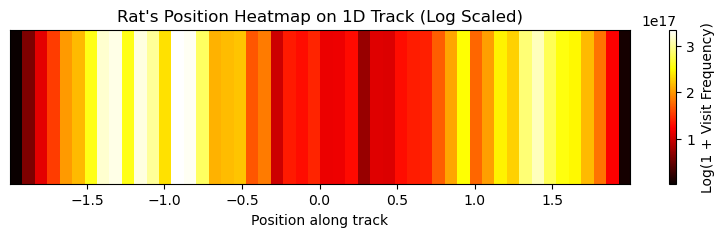

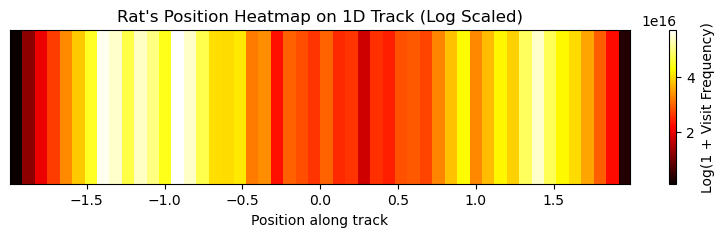

In [248]:
for m in all_ret1_models:
    positions = m

    # Convert to NumPy array for convenience
    positions = np.array(positions)

    # Define the number of bins (resolution of the heatmap)
    num_bins = 50  # or use a different value depending on your track granularity

    # Compute histogram
    counts, bin_edges = np.histogram(positions, bins=num_bins)
    
    # Apply log scaling (add 1 to avoid log(0))
    scale_counts = counts ** 3# log(1 + count)
    
    # Plot heatmap
    plt.figure(figsize=(10, 2))
    plt.imshow(scale_counts[np.newaxis, :], aspect='auto', cmap='hot',
               extent=[bin_edges[0], bin_edges[-1], 0, 1])
    plt.colorbar(label='Log(1 + Visit Frequency)')
    plt.title("Rat's Position Heatmap on 1D Track (Log Scaled)")
    plt.xlabel('Position along track')
    plt.yticks([])
    plt.show()


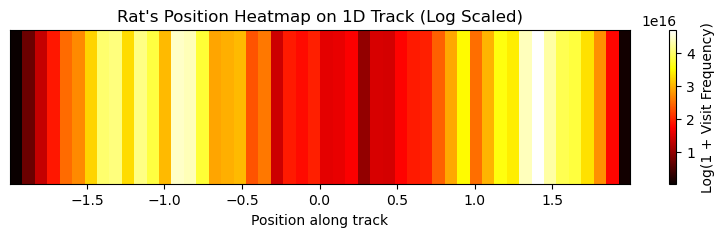

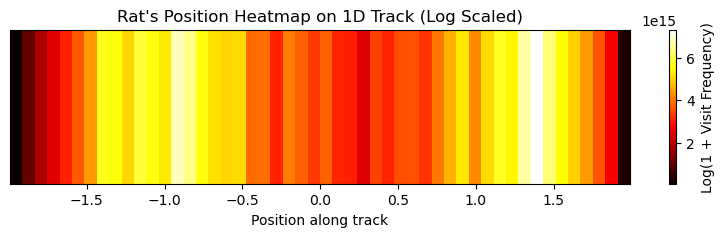

In [243]:
for m in all_ret1_models:
    positions = m

    # Convert to NumPy array for convenience
    positions = np.array(positions)

    # Define the number of bins (resolution of the heatmap)
    num_bins = 50  # or use a different value depending on your track granularity

    # Compute histogram
    counts, bin_edges = np.histogram(positions, bins=num_bins)
    
    # Apply log scaling (add 1 to avoid log(0))
    scale_counts = counts ** 3# log(1 + count)
    
    # Plot heatmap
    plt.figure(figsize=(10, 2))
    plt.imshow(scale_counts[np.newaxis, :], aspect='auto', cmap='hot',
               extent=[bin_edges[0], bin_edges[-1], 0, 1])
    plt.colorbar(label='Log(1 + Visit Frequency)')
    plt.title("Rat's Position Heatmap on 1D Track (Log Scaled)")
    plt.xlabel('Position along track')
    plt.yticks([])
    plt.show()


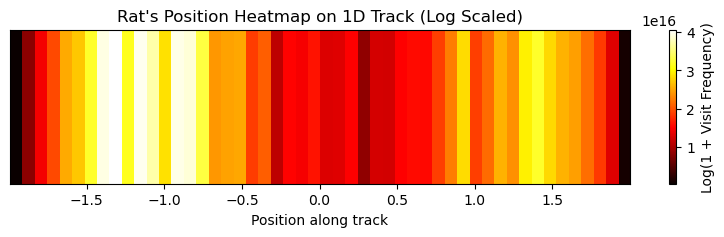

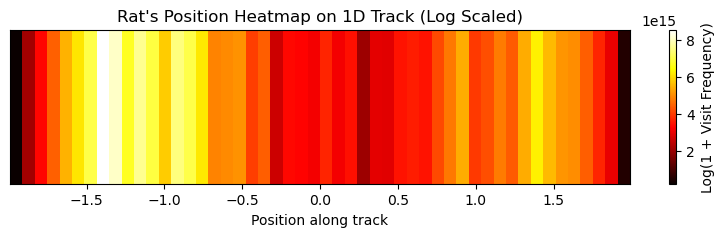

In [245]:
for m in all_ret2_models:
    positions = m

    # Convert to NumPy array for convenience
    positions = np.array(positions)
    
    # Define the number of bins (resolution of the heatmap)
    num_bins = 50  # or use a different value depending on your track granularity
    
    # Compute histogram
    counts, bin_edges = np.histogram(positions, bins=num_bins)
    
    # Apply log scaling (add 1 to avoid log(0))
    scale_counts = counts ** 3  # log(1 + count)
    
    # Plot heatmap
    plt.figure(figsize=(10, 2))
    plt.imshow(scale_counts[np.newaxis, :], aspect='auto', cmap='hot',
               extent=[bin_edges[0], bin_edges[-1], 0, 1])
    plt.colorbar(label='Log(1 + Visit Frequency)')
    plt.title("Rat's Position Heatmap on 1D Track (Log Scaled)")
    plt.xlabel('Position along track')
    plt.yticks([])
    plt.show()

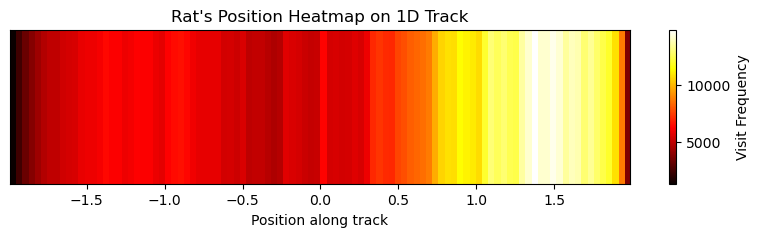

In [217]:
positions = gaze_pos

# Convert to NumPy array for convenience
positions = np.array(positions)

# Define the number of bins (resolution of the heatmap)
num_bins = 100  # or use a different value depending on your track granularity

# Compute histogram
counts, bin_edges = np.histogram(positions, bins=num_bins)

# Plot as a heatmap
plt.figure(figsize=(10, 2))
plt.imshow(counts[np.newaxis, :], aspect='auto', cmap='hot', extent=[bin_edges[0], bin_edges[-1], 0, 1])
plt.colorbar(label='Visit Frequency')
plt.title("Rat's Position Heatmap on 1D Track")
plt.xlabel('Position along track')
plt.yticks([])  # Hide y-axis as it's not meaningful in 1D
plt.show()


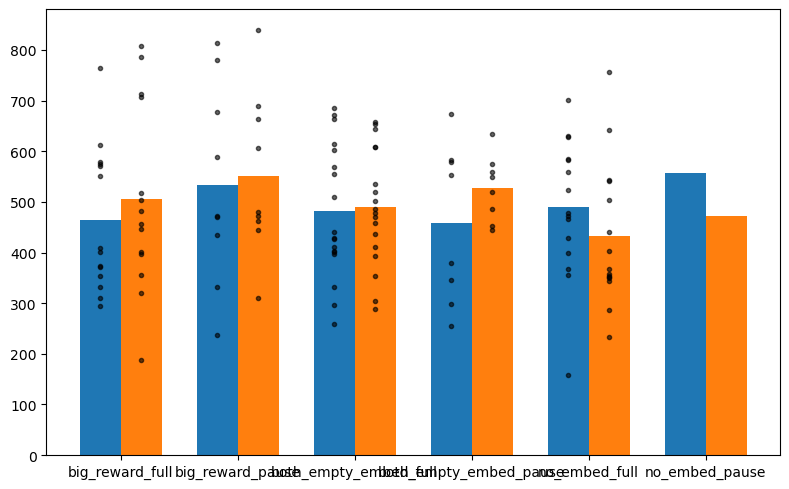

In [71]:
# Compute means
means1 = [np.mean(ret) for ret in all_ret1_models]
means2 = [np.mean(ret) for ret in all_ret2_models]

# Bar settings
x = np.arange(num_dir)  # the group locations
bar_width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars
bars1 = ax.bar(x - bar_width/2, means1, width=bar_width, label='Return 1', color='tab:blue')
bars2 = ax.bar(x + bar_width/2, means2, width=bar_width, label='Return 2', color='tab:orange')

# Plot individual points
for i in range(num_models):
    ax.plot(np.full_like(all_ret1_models[i], x[i] - bar_width/2), all_ret1_models[i], '.', color='k', alpha=0.6)
    ax.plot(np.full_like(all_ret2_models[i], x[i] + bar_width/2), all_ret2_models[i], '.', color='k', alpha=0.6)

# # Significance bars
# for i in range(num_models):
#     ret1 = all_ret1_models[i]
#     ret2 = all_ret2_models[i]
#     t_stat, p_val = ttest_ind(ret1, ret2)

#     y_max = max(means1[i], means2[i])
#     h = 0.1 * y_max if y_max != 0 else 0.1
#     y = y_max + h
#     ax.plot([x[i] - bar_width/2, x[i] - bar_width/2, x[i] + bar_width/2, x[i] + bar_width/2], 
#             [y, y + h, y + h, y], color='k')
    
#     # Label significance
#     if p_val < 0.001:
#         sig = '***'
#     elif p_val < 0.01:
#         sig = '**'
#     elif p_val < 0.05:
#         sig = '*'
#     else:
#         sig = 'n.s.'
#     ax.text(x[i], y + h + 0.02, sig, ha='center', va='bottom', fontsize=11)

# Final touches
ax.set_xticks(x)
ax.set_xticklabels(model_names)
# ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# graph_reward(model)
# graph_inter_press(model)
# graph_repress(model)
# graph_rat_id(model)
# graph_gaze(model)